In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from xarrayMannKendall import *

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:38329 Dashboard: /proxy/39967/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [2]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [3]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))

In [4]:
uas_cmip = {}; vas_cmip = {}
uas_cmip['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas_cmip['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))
# Individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

In [5]:
uas_cmip_proj = {}; vas_cmip_proj = {}
uas_cmip_proj['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc')['uas']
vas_cmip_proj['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_cmip_proj[model_name] = xr.open_dataset(path_uas[i])['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_cmip_proj[model_name] = xr.open_dataset(path_vas[i])['vas']
model_names = list(uas_cmip_proj.keys())

In [6]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

Historical trends

In [7]:
u = uas_cmip['CMIP6'].groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
u_cm_trends = MK_class.compute()

v = vas_cmip['CMIP6'].groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
v_cm_trends = MK_class.compute()

Projected trends

In [8]:
u = uas_cmip_proj['CMIP6'].groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
u_cmp_trends = MK_class.compute()

v = vas_cmip_proj['CMIP6'].groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
v_cmp_trends = MK_class.compute()

In [9]:
u_cm_trends = u_cm_trends.rename({'x':'lon', 'y':'lat'})
u_cmp_trends = u_cmp_trends.rename({'x':'lon', 'y':'lat'})
v_cm_trends = v_cm_trends.rename({'x':'lon', 'y':'lat'})
v_cmp_trends = v_cmp_trends.rename({'x':'lon', 'y':'lat'})

In [10]:
div_lin = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

KeyError: 'lon'

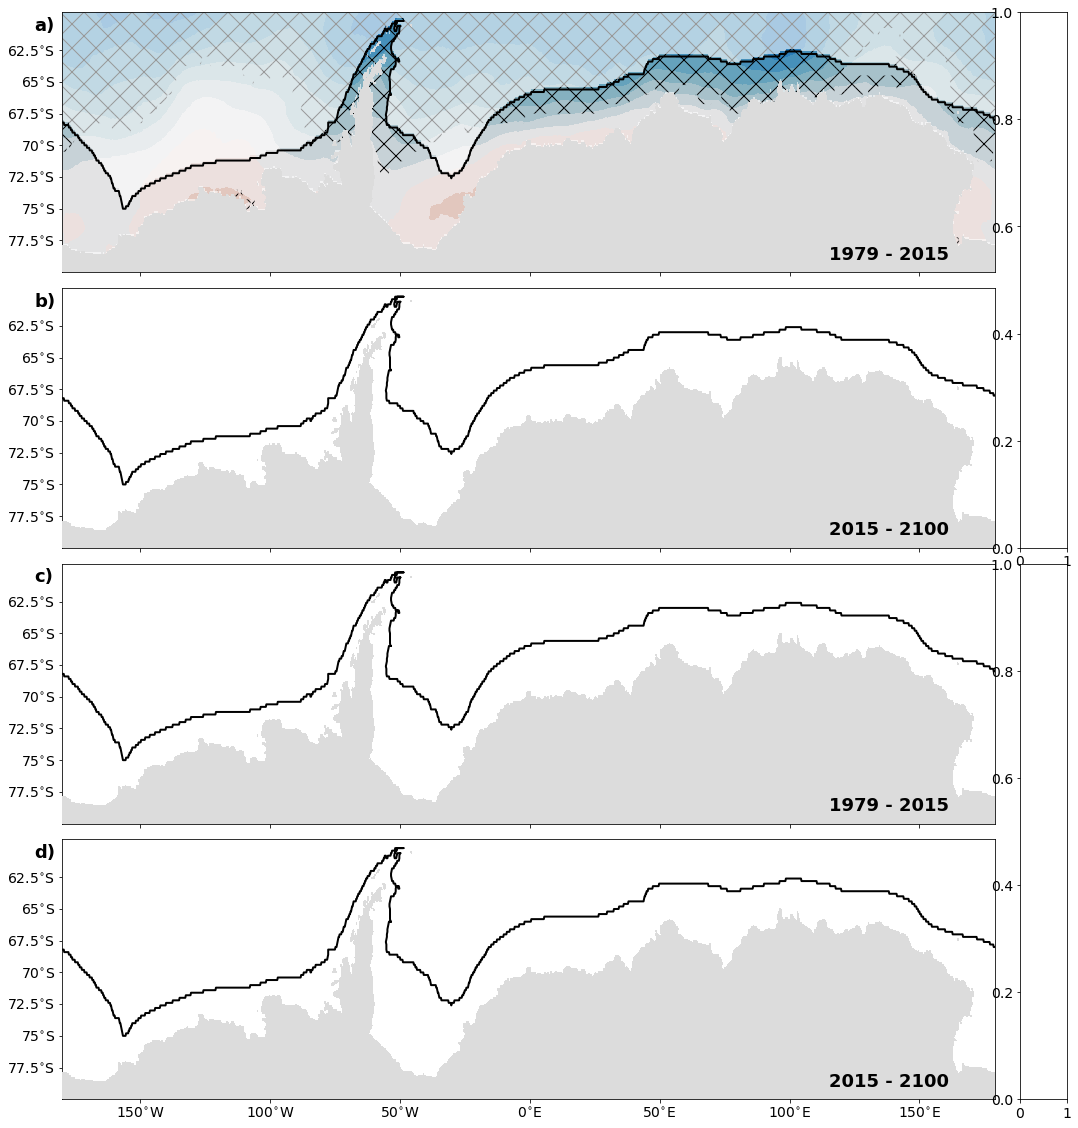

In [18]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[:2,1]), 
       fig.add_subplot(gr[2:,1])]
for ax, label in zip(axs[:-1], ['a)', 'b)', 'c)', 'd)']):
    ax.text(-0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    if ax in [axs[0], axs[2]]:
        ax.text(0.95, .05, '1979 - 2015', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    else:
        ax.text(0.95, .05, '2015 - 2100', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    
c = axs[0].contourf(u_cm_trends['lon'], u_cm_trends['lat'], -u_cm_trends['trend']*10, levels = np.arange(-.3, .325, .025), extend = 'both',
                      cmap = cmocean.cm.balance)
axs[0].contourf(u_cm_trends['lon'], u_cm_trends['lat'], u_cm_trends['p'].where(u_cm_trends['p'] <= .05),
                colors = ['none'], hatches = ['x'])
axs[1].contourf(u_cmp_trends['lon'], u_cmp_trends['lat'], -u_cmp_trends['trend']*10, levels = np.arange(-.3, .325, .025), extend = 'both',
                      cmap = cmocean.cm.balance)
axs[1].contourf(u_cmp_trends['lon'], u_cmp_trends['lat'], u_cmp_trends['p'].where(u_cmp_trends['p'] <= .05),
                colors = ['none'], hatches = ['x'])
fig.colorbar(c, cax = axs[-2], orientation = 'vertical').set_label('Easterly wind trend [m/s dec${-1}$]')
c = axs[2].contourf(v_cm_trends['lon'], v_cm_trends['lat'], v_cm_trends['trend']*10, levels = np.arange(-.1, .11, .01), extend = 'both',
                      cmap = cmocean.cm.balance)
axs[2].contourf(v_cm_trends['lon'], v_cm_trends['lat'], v_cm_trends['p'].where(v_cm_trends['p'] <= .05),
                colors = ['none'], hatches = ['x'])
c = axs[3].contourf(v_cmp_trends['lon'], v_cmp_trends['lat'], v_cmp_trends['trend']*10, levels = np.arange(-.1, .11, .01), extend = 'both',
                      cmap = cmocean.cm.balance)
axs[3].contourf(v_cmp_trends['lon'], v_cmp_trends['lat'], v_cmp_trends['p'].where(v_cmp_trends['p'] <= .05),
                colors = ['none'], hatches = ['x'])
fig.colorbar(c, cax = axs[-1], orientation = 'vertical').set_label('Southerly wind trend [m/s dec${-1}$]')
plt.savefig('../results/v4/fig3.jpg', bbox_inches = 'tight')

# Supplementary

In [12]:
u_res_trends = {}
v_res_trends = {}
for k in keys[:-1]:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    u_res_trends[k] = MK_class.compute()

    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    v_res_trends[k] = MK_class.compute()

In [13]:
u_cmp_trends = {}
v_cmp_trends = {}
for k in model_keys:
    u = uas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    u_cmp_trends[k] = MK_class.compute()

    v = vas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    v_cmp_trends[k] = MK_class.compute()

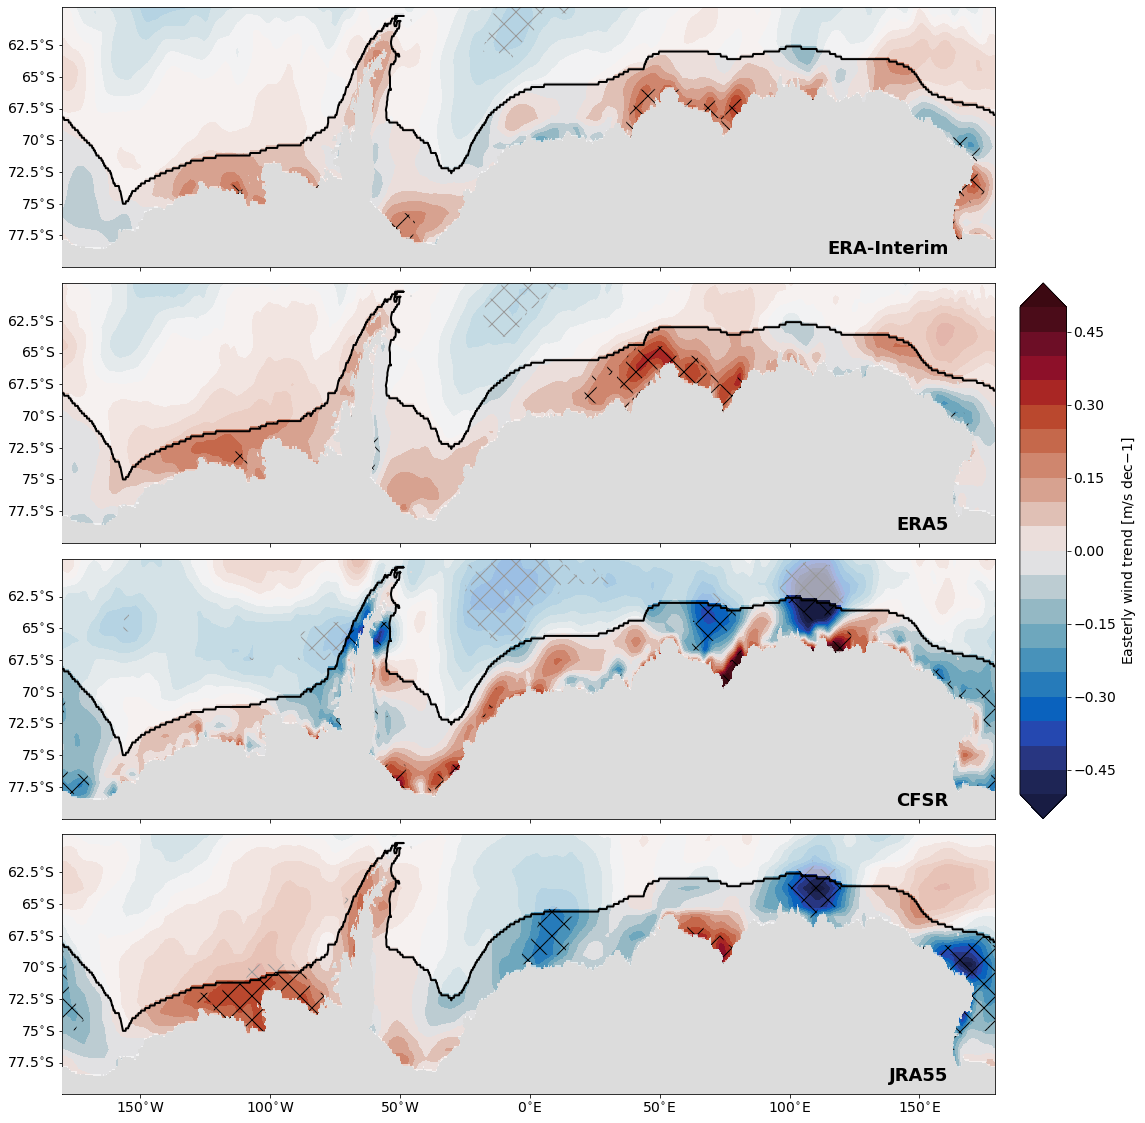

In [14]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], keys):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-1]:
    c = axs[n].contourf(u_res_trends[k]['x'], u_res_trends[k]['y'], -u_res_trends[k]['trend']*10, 
                        levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(u_res_trends[k]['x'], u_res_trends[k]['y'], 
                    u_res_trends[k]['p'].where(u_res_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['x'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Easterly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v4/figsup3.jpg', bbox_inches = 'tight')

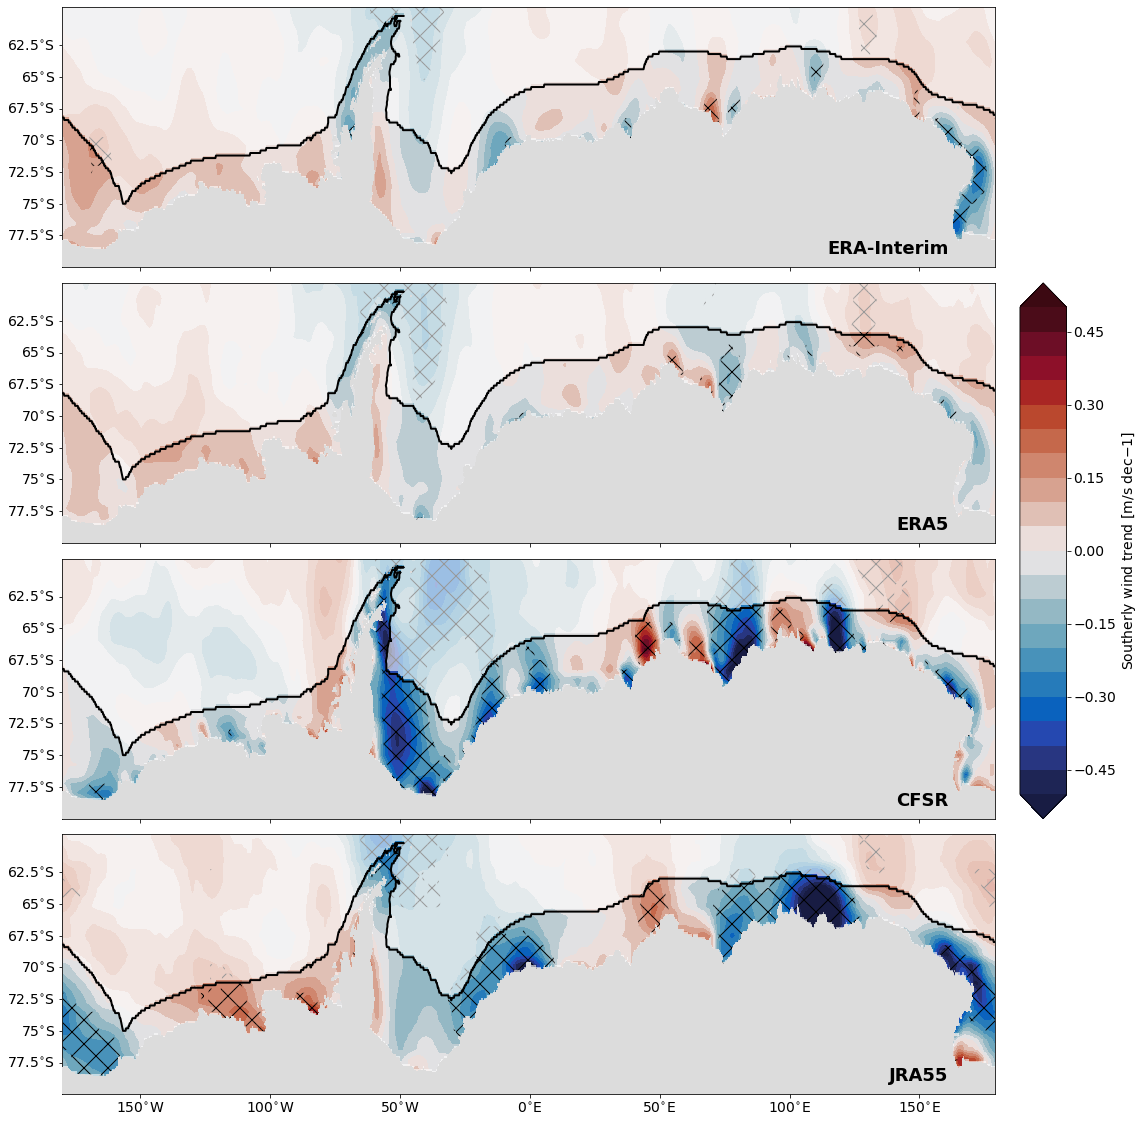

In [19]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], keys):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-1]:
    c = axs[n].contourf(u_res_trends[k]['x'], u_res_trends[k]['y'], v_res_trends[k]['trend']*10, 
                        levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(u_res_trends[k]['x'], u_res_trends[k]['y'], 
                    v_res_trends[k]['p'].where(v_res_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['x'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Southerly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v4/figsup4.jpg', bbox_inches = 'tight')

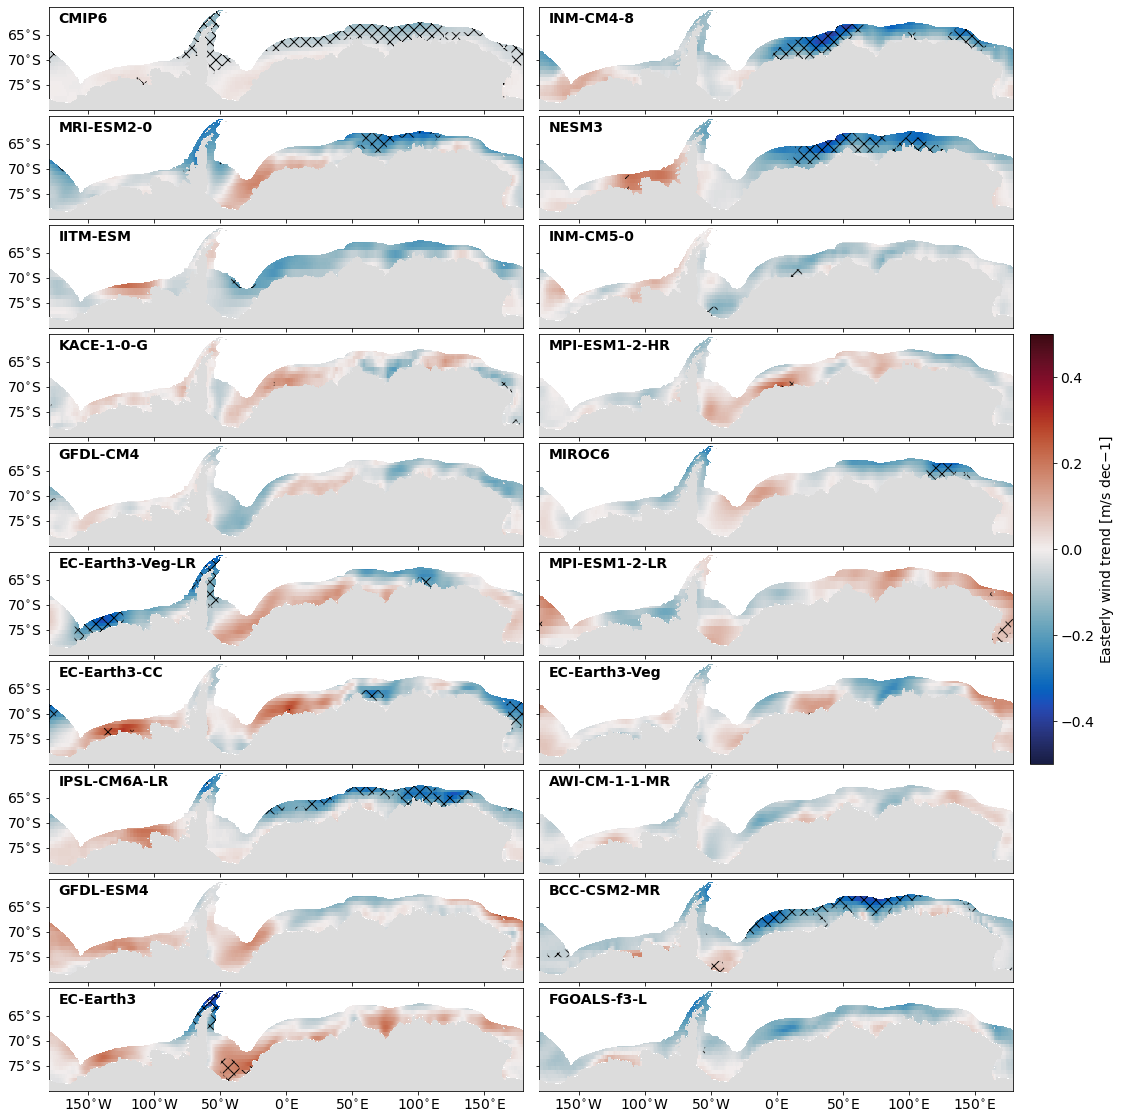

In [16]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]), 
       fig.add_subplot(gr[9,1]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.text(0.02, .85, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18], axs[20]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
n = 0
for k in model_keys:
    c = axs[n].pcolormesh(u_cmp_trends[k]['x'], u_cmp_trends[k]['y'], -u_cmp_trends[k]['trend']*10, vmin = -.5, vmax = .5,
                          cmap = cmocean.cm.balance)
    axs[n].contourf(u_cmp_trends[k]['x'], u_cmp_trends[k]['y'], u_cmp_trends[k]['p'].where(u_cmp_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['xx'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Easterly wind trend [m/s dec${-1}$]')
plt.savefig('../results/v4/figsup5.jpg', bbox_inches = 'tight')

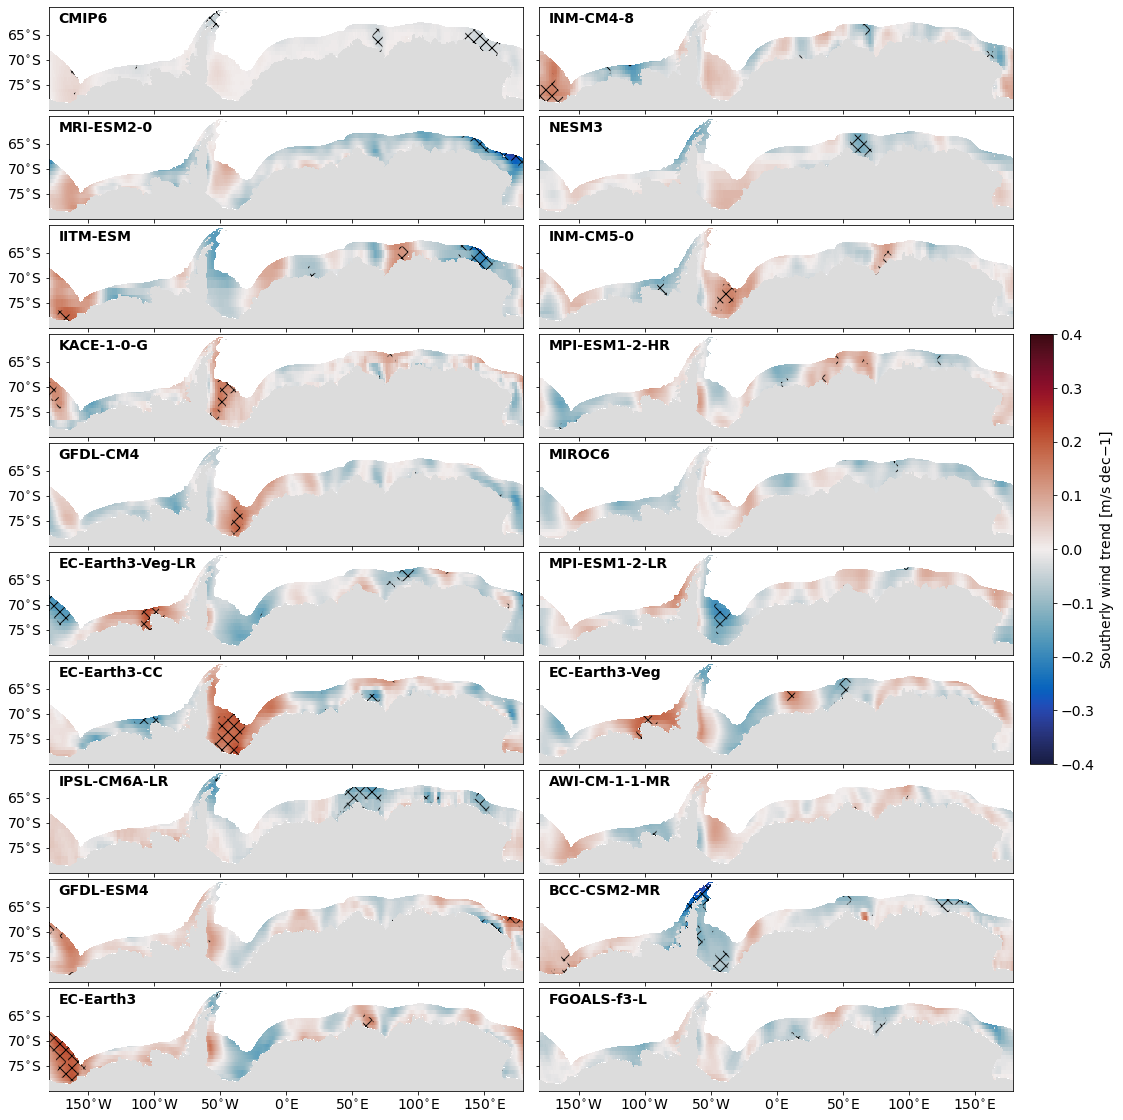

In [20]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]), 
       fig.add_subplot(gr[9,1]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.text(0.02, .85, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18], axs[20]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
n = 0
for k in model_keys:
    c = axs[n].pcolormesh(u_cmp_trends[k]['x'], u_cmp_trends[k]['y'], v_cmp_trends[k]['trend']*10, vmin = -.4, vmax = .4,
                          cmap = cmocean.cm.balance)
    axs[n].contourf(u_cmp_trends[k]['x'], u_cmp_trends[k]['y'], v_cmp_trends[k]['p'].where(v_cmp_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['xx'])
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Southerly wind trend [m/s dec${-1}$]')
plt.savefig('../results/v4/figsup6.jpg', bbox_inches = 'tight')